In [2]:
import numpy as np
import pandas as pd

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [7]:
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

# EDA

In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [9]:
movies.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [10]:
# checking correlations between popularity, vote_count and vote_average
print(movies['vote_average'].corr(movies['popularity']))
print(movies['vote_count'].corr(movies['popularity']))
print(movies['vote_average'].corr(movies['vote_count']))

# popularity and vote_count have high correlation

0.27395182861902767
0.7781298890348539
0.31299740399575976


In [13]:
# checking correlations between popularity,vote_average and revenue, budget
print(movies['budget'].corr(movies['popularity']))
print(movies['revenue'].corr(movies['popularity']))
print((movies['revenue'] - movies['budget']).corr(movies['popularity']))
print(movies['revenue'].corr(movies['vote_average']))

# revenue is kind of related to popularity - which makes sense as more people know about the movie

0.5054139990665322
0.644723504555998
0.6208543203014802
0.1971496658113086


<Axes: xlabel='vote_average', ylabel='budget'>

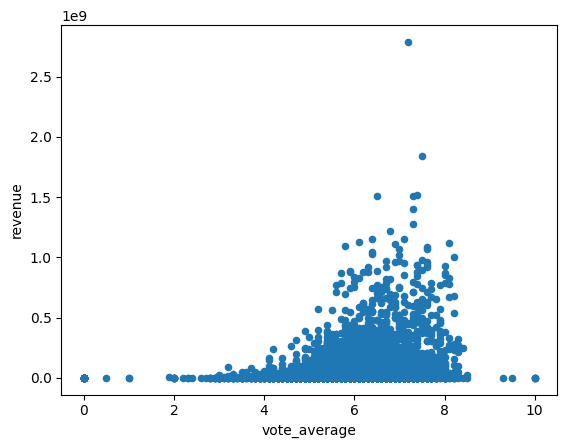

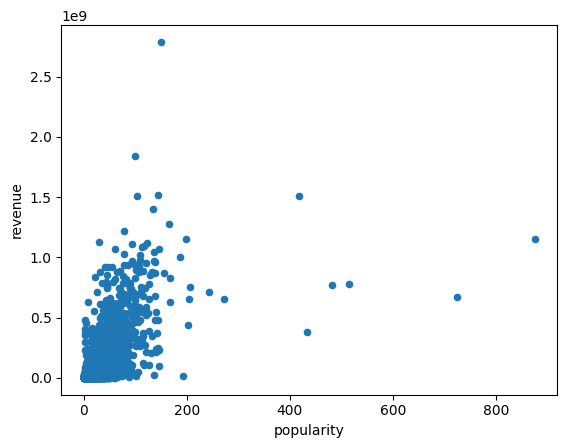

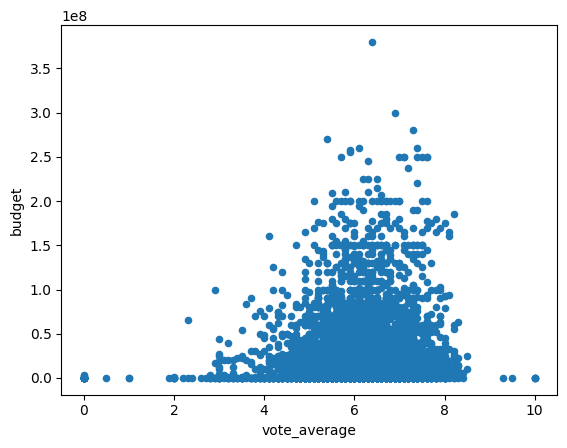

In [14]:
# plots to vizualize the above correlations
movies.plot.scatter(x='vote_average', y='revenue')
movies.plot.scatter(x='popularity', y='revenue')
movies.plot.scatter(x='vote_average', y='budget')

<Axes: ylabel='count'>

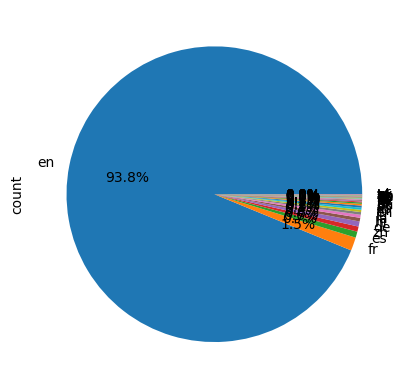

In [15]:
# analysing if language can be a factor that affects users choice
movies['original_language'].value_counts().plot(kind = 'pie', autopct='%1.1f%%')

# highly skewed towards english language

In [16]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [17]:
credits.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


# Content-based Recommendation System

# Data Pre-processing for content based filtering

In [18]:
new_df = movies.loc[:,['id','genres','overview','keywords','title']]
new_df.sample()

,id,genres,overview,keywords,title
2421,13960,"[{""id"": 18, ""name"": ""Drama""}]",As four friends prepare for life after high sc...,[],ATL


In [19]:
new_df.shape

(4803, 5)

In [20]:
new_df = new_df.drop_duplicates(subset=['id'])

In [21]:
new_df = new_df.merge(credits.drop(columns = 'title'), left_on = 'id', right_on = 'movie_id').drop_duplicates(subset=['id'])

In [22]:
new_df.iloc[[1]]

,id,genres,overview,keywords,title,movie_id,cast,crew
1,285,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","Captain Barbossa, long believed to be dead, ha...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",Pirates of the Caribbean: At World's End,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [23]:
new_df.shape

(4803, 8)

In [24]:
new_df.isna().sum()

id          0
genres      0
overview    3
keywords    0
title       0
movie_id    0
cast        0
crew        0
dtype: int64

In [25]:
new_df.iloc[1].genres

'[{"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}]'

In [26]:
type(new_df.iloc[1].genres)

str

In [27]:
# to identify list objects formatted as strings
import ast
ast.literal_eval(new_df.iloc[1].genres)

[{'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 28, 'name': 'Action'}]

In [28]:
# to extract genres and keywords as list of words
def genkeyw(obj):
    l = []
    for i in ast.literal_eval(obj):
        l.append(i['name'])
    return l

In [29]:
new_df.genres = new_df.genres.apply(genkeyw)

In [30]:
new_df.keywords = new_df.keywords.apply(genkeyw)

In [31]:
new_df.sample(1)

,id,genres,overview,keywords,title,movie_id,cast,crew
818,109424,"[Action, Drama, Thriller]",The true story of Captain Richard Phillips and...,"[ship, hijacking, somalia, fisherman, blood, p...",Captain Phillips,109424,"[{""cast_id"": 10, ""character"": ""Captain Richard...","[{""credit_id"": ""52fe4ab5c3a36847f81dd519"", ""de..."


In [32]:
# to fetch the name of the director of the movie
def get_director(x):
    for i in ast.literal_eval(x):
        if i['job'] == 'Director':
            return i['name']
    return np.nan        

In [33]:
new_df['director'] = new_df['crew'].apply(get_director)

In [34]:
new_df.drop('crew', axis=1, inplace=True)

In [35]:
# to get the top 4 cast members of a movie
def get_cast(x):
    l=[]
    for i in ast.literal_eval(x):
        l.append(i['name'])
    if(len(l)>4):
        l = l[:4]
    return l

In [36]:
new_df.cast = new_df.cast.apply(get_cast)

In [37]:
new_df.sample(1)

,id,genres,overview,keywords,title,movie_id,cast,director
1007,96724,"[Drama, Romance]","Trapped in a loveless marriage, aristocrat Ann...","[based on novel, st. petersburg russia, high s...",Anna Karenina,96724,"[Keira Knightley, Jude Law, Aaron Taylor-Johns...",Joe Wright


In [38]:
new_df.isna().sum()

id           0
genres       0
overview     3
keywords     0
title        0
movie_id     0
cast         0
director    30
dtype: int64

In [39]:
# Function to remove spaces and convert strings to lower case
def remove_space(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        # Remove space from director and return empty string if director not present
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [40]:
# converting all columns to proper format
new_df.genres = new_df.genres.apply(remove_space)
new_df.keywords = new_df.keywords.apply(remove_space)
new_df.cast = new_df.cast.apply(remove_space)
new_df.director = new_df.director.apply(remove_space)

In [41]:
new_df.head(1)

,id,genres,overview,keywords,title,movie_id,cast,director
0,19995,"[action, adventure, fantasy, sciencefiction]","In the 22nd century, a paraplegic Marine is di...","[cultureclash, future, spacewar, spacecolony, ...",Avatar,19995,"[samworthington, zoesaldana, sigourneyweaver, ...",jamescameron


In [42]:
# creating tags column to store important words that represent a movie
new_df['tags'] = new_df.genres + new_df.keywords + new_df.cast

In [43]:
new_df.drop(columns=['cast','genres','keywords'], inplace = True)

In [44]:
# adding director's name to tags
for i in new_df.index:
    new_df['tags'][i].append(new_df['director'][i])

In [45]:
new_df.drop('director',axis = 1,inplace = True)

In [46]:
# converting overview and title to string, if not already
new_df.overview = new_df.overview.astype(str)
new_df.title = new_df.title.astype(str)

In [47]:
# splitting overview string to a list of words
new_df.overview = new_df.overview.apply(lambda x:x.split())

In [48]:
# adding overview to tags
new_df.tags = new_df.overview + new_df.tags

In [49]:
new_df.drop(columns = ['overview','movie_id'], inplace =True)

In [50]:
# converting tags back to a string with all important words
new_df.tags = new_df.tags.apply(lambda x:" ".join(x))

In [51]:
new_df.tags = new_df.tags.apply(lambda x: x.lower())

In [52]:
# importing for stemming of words
import nltk
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [54]:
# funtion to stem all words i.e. likes,liked,likely,liking = like
# results in no exteremely similar words 
def stem(text):
    list_of_words = []
    
    for word in text.split():
        list_of_words.append(ps.stem(word))
    
    return " ".join(list_of_words)

In [55]:
new_df.tags = new_df.tags.apply(stem)

In [56]:
# Import Tf-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a TF-IDF Vectorizer Object that also removes all english stop words
tfidf = TfidfVectorizer(stop_words='english')

# Replace NaN with an empty string
new_df['tags'] = new_df['tags'].fillna('')

# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(new_df['tags']).toarray()


tfidf_matrix.shape

(4803, 34756)

In [57]:
# Import Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
similarity = cosine_similarity(tfidf_matrix)

In [58]:
similarity.shape

(4803, 4803)

In [61]:
# recommendation function
def CB_recomend(movie):
    # fetch index
    idx = new_df[new_df['title'] == movie].index[0]
    # extract 5 most similar movies
    sim_movies = sorted(list(enumerate(similarity[idx])), key = lambda x:x[1], reverse =True)[1:6]
    
    # display 5 most similar movies
    for i in sim_movies:
        print(new_df.iloc[i[0]].title)

In [62]:
CB_recomend('Batman Begins')

The Dark Knight
The Dark Knight Rises
Batman
Batman Returns
Batman v Superman: Dawn of Justice


# Collaborative Filtering Recommendation System

In [65]:
new_df

,id,title,tags
0,19995,Avatar,"in the 22nd century, a parapleg marin is dispa..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believ to be dead, ha c..."
2,206647,Spectre,a cryptic messag from bond’ past send him on a...
3,49026,The Dark Knight Rises,follow the death of district attorney harvey d...
4,49529,John Carter,"john carter is a war-weary, former militari ca..."
...,...,...,...
4798,9367,El Mariachi,el mariachi just want to play hi guitar and ca...
4799,72766,Newlyweds,a newlyw couple' honeymoon is upend by the arr...
4800,231617,"Signed, Sealed, Delivered","""signed, sealed, delivered"" introduc a dedic q..."
4801,126186,Shanghai Calling,when ambiti new york attorney sam is sent to s...


In [66]:
# code generated ratings
ratings = pd.read_csv('ratings.csv')

In [67]:
# we have 3042 out of 4803 movies that are rated
len(sorted(ratings.groupby('movie_id').count()['rating'], reverse=True))

3076

In [68]:
ratings_with_title = ratings.merge(new_df, left_on = 'movie_id', right_on = 'id')
ratings_with_title

,movie_id,user_id,rating,id,title,tags
0,96,100,1.742628,96,Beverly Hills Cop II,"detroit cop, axel foley head for the land of s..."
1,107,161,4.240211,107,Snatch,the second film from british director guy ritc...
2,10030,175,0.979824,10030,Good Luck Chuck,"curs sinc childhood, dentist charli kagan cann..."
3,81188,107,2.957260,81188,Rise of the Guardians,when an evil spirit known as pitch lay down th...
4,155,215,4.009831,155,The Dark Knight,batman rais the stake in hi war on crime. with...
...,...,...,...,...,...,...
19995,49524,159,1.264297,49524,R.I.P.D.,a recent slain cop join a team of undead polic...
19996,8909,170,3.548074,8909,Wanted,doormat wesley gibson discov that hi recent mu...
19997,70160,112,2.974780,70160,The Hunger Games,everi year in the ruin of what wa onc north am...
19998,87421,132,5.000000,87421,Riddick,betray by hi own kind and left for dead on a d...


In [69]:
# we consider ratings from users who rate movies frequently, atleast 50 ratings
woke_users = ratings_with_title.groupby('user_id').count()['rating'][ratings_with_title.groupby('user_id')
                                                               .count()['rating'] >= 50].index

In [70]:
filtered_ratings = ratings_with_title[ratings_with_title['user_id'].isin(woke_users)]
filtered_ratings

,movie_id,user_id,rating,id,title,tags
0,96,100,1.742628,96,Beverly Hills Cop II,"detroit cop, axel foley head for the land of s..."
1,107,161,4.240211,107,Snatch,the second film from british director guy ritc...
2,10030,175,0.979824,10030,Good Luck Chuck,"curs sinc childhood, dentist charli kagan cann..."
3,81188,107,2.957260,81188,Rise of the Guardians,when an evil spirit known as pitch lay down th...
6,132363,160,3.633031,132363,The Butler,a look at the life of cecil gain who serv eigh...
...,...,...,...,...,...,...
19994,9367,160,4.191092,9367,El Mariachi,el mariachi just want to play hi guitar and ca...
19995,49524,159,1.264297,49524,R.I.P.D.,a recent slain cop join a team of undead polic...
19996,8909,170,3.548074,8909,Wanted,doormat wesley gibson discov that hi recent mu...
19997,70160,112,2.974780,70160,The Hunger Games,everi year in the ruin of what wa onc north am...


In [71]:
# we only consider movies rated by atleast 3 users
more_rated_movies =filtered_ratings.groupby('movie_id').count()['rating'][
    filtered_ratings.groupby('movie_id').count()['rating'] > 3].index

In [72]:
# all credible ratings
final_ratings = filtered_ratings[filtered_ratings['movie_id'].isin(more_rated_movies)]

In [73]:
final_ratings.reset_index(inplace = True)

In [74]:
final_ratings.drop('index', axis =1, inplace = True)

C:\Users\Kunal\AppData\Local\Temp\ipykernel_8280\3203548128.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_ratings.drop('index', axis =1, inplace = True)


In [75]:
final_ratings

,movie_id,user_id,rating,id,title,tags
0,96,100,1.742628,96,Beverly Hills Cop II,"detroit cop, axel foley head for the land of s..."
1,107,161,4.240211,107,Snatch,the second film from british director guy ritc...
2,10030,175,0.979824,10030,Good Luck Chuck,"curs sinc childhood, dentist charli kagan cann..."
3,81188,107,2.957260,81188,Rise of the Guardians,when an evil spirit known as pitch lay down th...
4,132363,160,3.633031,132363,The Butler,a look at the life of cecil gain who serv eigh...
...,...,...,...,...,...,...
12196,37735,189,3.811460,37735,Easy A,after a littl white lie about lose her virgin ...
12197,49524,159,1.264297,49524,R.I.P.D.,a recent slain cop join a team of undead polic...
12198,8909,170,3.548074,8909,Wanted,doormat wesley gibson discov that hi recent mu...
12199,70160,112,2.974780,70160,The Hunger Games,everi year in the ruin of what wa onc north am...


In [76]:
# creating a pivot table
pt = final_ratings.pivot_table(index = 'title', columns = 'user_id', values='rating')
pt

user_id,100,101,102,103,104,105,106,107,108,109,...,191,192,193,195,199,200,202,203,217,1000
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer,NaN,NaN,NaN,NaN,NaN,1.299528,NaN,NaN,NaN,1.558574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10 Cloverfield Lane,NaN,NaN,3.742261,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,4.562562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10 Things I Hate About You,NaN,NaN,NaN,NaN,NaN,NaN,0.634198,5.000000,NaN,3.950046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men,NaN,3.557412,NaN,NaN,NaN,1.749233,NaN,2.798852,NaN,3.999697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.576521
12 Rounds,NaN,NaN,NaN,NaN,NaN,NaN,2.507410,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.372147,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zombieland,3.771710,NaN,0.405906,1.818915,1.443233,4.832664,NaN,NaN,NaN,NaN,...,NaN,NaN,3.580598,1.039948,NaN,NaN,NaN,NaN,NaN,2.865439
Zoolander,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[REC],4.314893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
# Normalisation of pivot table values
row_means = pt.mean(axis=1, skipna=True)
pt = pt.apply(lambda row: row.sub(row_means[row.name]) if row.name in row_means else row, axis=1)
pt.fillna(0, inplace = True)

In [78]:
pt

user_id,100,101,102,103,104,105,106,107,108,109,...,191,192,193,195,199,200,202,203,217,1000
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer,0.000000,0.00000,0.000000,0.000000,0.000000,-1.888330,0.000000,0.000000,0.0,-1.629284,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
10 Cloverfield Lane,0.000000,0.00000,1.020295,0.000000,0.000000,-2.721966,0.000000,0.000000,0.0,0.000000,...,1.840596,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
10 Things I Hate About You,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-2.730937,1.634864,0.0,0.584910,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
12 Angry Men,0.000000,0.27907,0.000000,0.000000,0.000000,-1.529109,0.000000,-0.479490,0.0,0.721356,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,-1.701821
12 Rounds,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-1.646978,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.217759,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zombieland,1.358665,0.00000,-2.007140,-0.594131,-0.969813,2.419618,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,1.167552,-1.373098,0.0,0.0,0.0,0.0,0.000000,0.452393
Zoolander,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
[REC],1.136151,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [79]:
# Compute the cosine similarity matrix
colab_sim = cosine_similarity(pt)

colab_sim.shape

(1255, 1255)

In [84]:
# recommendation function
def CF_recommend(movie):
    # index fetch 
    index = np.where(pt.index==movie)[0][0]
    similar_items = sorted(list(enumerate(colab_sim[index])),key=lambda x:x[1], reverse = True)[1:6]
    
    for i in similar_items:
        print(pt.index[i[0]])

In [85]:
CF_recommend('Jurassic Park')

Paul
Disturbia
American Wedding
13 Going on 30
Paper Towns


# Hybrid Reccomendation System

## Trimming Content-based Data
- keeping only those movies which have credible ratings and for whom we have collaborative filtering similarity scores

In [86]:
new_df

,id,title,tags
0,19995,Avatar,"in the 22nd century, a parapleg marin is dispa..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believ to be dead, ha c..."
2,206647,Spectre,a cryptic messag from bond’ past send him on a...
3,49026,The Dark Knight Rises,follow the death of district attorney harvey d...
4,49529,John Carter,"john carter is a war-weary, former militari ca..."
...,...,...,...
4798,9367,El Mariachi,el mariachi just want to play hi guitar and ca...
4799,72766,Newlyweds,a newlyw couple' honeymoon is upend by the arr...
4800,231617,"Signed, Sealed, Delivered","""signed, sealed, delivered"" introduc a dedic q..."
4801,126186,Shanghai Calling,when ambiti new york attorney sam is sent to s...


In [87]:
# we fetch all the movie ids on which collaborative filtering could be applied i.e. final_ratings

movie_ids = final_ratings.movie_id.unique()
len(movie_ids)

1255

In [88]:
# filtering new_df for Content-based approach

new_CB_df = new_df[new_df['id'].isin(movie_ids)].sort_values(by = 'title').reset_index()

In [89]:
new_CB_df.drop(columns = 'index' , inplace = True)

In [90]:
new_CB_df

,id,title,tags
0,19913,(500) Days of Summer,"tom (joseph gordon-levitt), greeting-card writ..."
1,333371,10 Cloverfield Lane,"after a car accident, michel awaken to find he..."
2,4951,10 Things I Hate About You,"bianca, a tenth grader, ha never gone on a dat..."
3,389,12 Angry Men,the defens and the prosecut have rest and the ...
4,17134,12 Rounds,when new orlean cop danni fisher prevent a bri...
...,...,...,...
1250,19908,Zombieland,columbu ha made a habit of run from what scare...
1251,9398,Zoolander,"clear the runway for derek zoolander, vh1' thr..."
1252,8329,[REC],a televis report and cameraman follow emerg wo...
1253,7451,xXx,xander cage is your standard adrenalin junki w...


In [91]:
# tfidf_vectorizer already imported in Content-based Recommendation System
# Using same tfidf vectorizer object as above
tfidf = TfidfVectorizer(stop_words='english')

# Replace NaN with an empty string
new_CB_df['tags'] = new_CB_df['tags'].fillna('')

# Construct the required TF-IDF matrix by fitting and transforming the data
matrix_CB = tfidf.fit_transform(new_CB_df['tags']).toarray()

matrix_CB.shape

(1255, 15126)

In [92]:
# Compute the cosine similarity matrix
cont_sim = cosine_similarity(matrix_CB)

In [93]:
cont_sim.shape

(1255, 1255)

In [94]:
colab_sim.shape

(1255, 1255)

In [95]:
# we get hybrid similarity matrix by using weighted sum of the similarities by 2 methods
hyb_sim = (colab_sim * 0) + (cont_sim * 1)

In [96]:
# recommendation function
def hybrid_recco(movie):
        
    # fetch index
    ind = new_CB_df[new_CB_df.title == movie].index[0]
    similar_movies = sorted(list(enumerate(hyb_sim[ind])),key=lambda x:x[1], reverse = True)[1:8]
    
    for i in similar_movies:
        print(list(new_CB_df[new_CB_df.index == i[0]].title)[0])

In [97]:
hybrid_recco('xXx')

Mission: Impossible - Rogue Nation
Journey 2: The Mysterious Island
Mission: Impossible - Ghost Protocol
Criminal
G-Force
Faster
Lone Survivor


In [117]:
popular_df = movies.sort_values(by = 'popularity' , ascending= False).head(50)[['id','title','popularity']]

In [119]:
pickle.dump(popular_df,open('popular.pkl','wb'))

In [120]:
pickle.dump(pt,open('pt.pkl','wb'))
pickle.dump(new_CB_df,open('movies.pkl','wb'))
pickle.dump(hyb_sim,open('similarity_scores.pkl','wb'))